### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from IPython.display import Image

# read earthquake data set
earthquake = pd.read_csv('disp_data.csv')

### Logistic regression

In [2]:
# dispVar = 1 if displacement greater than 1 cm occurs, 0 otherwise
dispVar = (earthquake['Disp'] > 1).astype('int64')
earthquake = earthquake.assign(dispVar = dispVar)

# create training and test sets; training set uses 80% of the data
earthquakeTraining, earthquakeTest = train_test_split(earthquake, test_size=0.20, random_state=404)

# create training and test variables using the 5 most relevant features identified from forwards/backwards selection
X_train = earthquakeTraining[['KY1', 'PGV', 'T0050S', 'sa10', 'T']]
y_train = earthquakeTraining['dispVar']
X_test = earthquakeTest[['KY1', 'PGV', 'T0050S', 'sa10', 'T']]
y_test = earthquakeTest['dispVar']

# perform log transformation on training and test sets, except on columns containing zero or negative values
X_train_log=np.log(X_train.drop(columns=['T', 'KY1']))
X_test_log=np.log(X_test.drop(columns=['T','KY1']))

# add back in columns that cannot be log transformed
X_train_log[['T','KY1']]=X_train[['T','KY1']]
X_test_log[['T', 'KY1']]=X_test[['T', 'KY1']]
print(X_train_log)

            PGV    T0050S      sa10        T    KY1
8136   1.396962 -3.405145 -2.324657  0.19783  0.250
31194  0.411977 -4.623232 -3.789938  0.19978  0.075
522    4.503149  0.524610  0.746783  0.49892  0.150
6654   2.040597 -2.310224 -1.682493  0.10000  0.200
13627 -0.796377 -4.729487 -6.142241  2.00060  0.075
...         ...       ...       ...      ...    ...
38799 -0.835702 -3.940834 -5.385227  0.30203  0.250
37876  0.361444 -4.078019 -3.325404  0.69675  0.300
14186  1.132208 -3.759216 -3.515498  0.19783  0.035
5884   2.586184 -3.147602 -2.838147  0.10000  0.020
7911   0.291251 -3.695300 -2.846830  0.30136  0.050

[39602 rows x 5 columns]


In [3]:
# Perform logistic regression using these features to classify cases between "displacement" and "no displacement"
earthquakeLR = LogisticRegression(solver='lbfgs', max_iter=500)
earthquakeLR.fit(X_train_log, y_train)              # uses training data to fit regression
y_lrPred_train = earthquakeLR.predict(X_train_log)  # predicts y from training data of x
y_lrPred_test = earthquakeLR.predict(X_test_log)

# get test error
lrTrain_acc = metrics.accuracy_score(y_train, y_lrPred_train)
lrTrain_error = 1 - lrTrain_acc
lrTest_acc = metrics.accuracy_score(y_test, y_lrPred_test)
lrTest_error = 1 - lrTest_acc
print('Logistic regression training error is', lrTrain_error)
print('Logistic regression test error is', lrTest_error)

print(earthquakeLR.classes_)
print(earthquakeLR.intercept_)
print(earthquakeLR.coef_)

Logistic regression training error is 0.05057825362355439
Logistic regression test error is 0.04625795374204622
[0 1]
[3.93104208]
[[  1.04710411  -0.19771333   2.25697531   0.34875998 -27.86453327]]


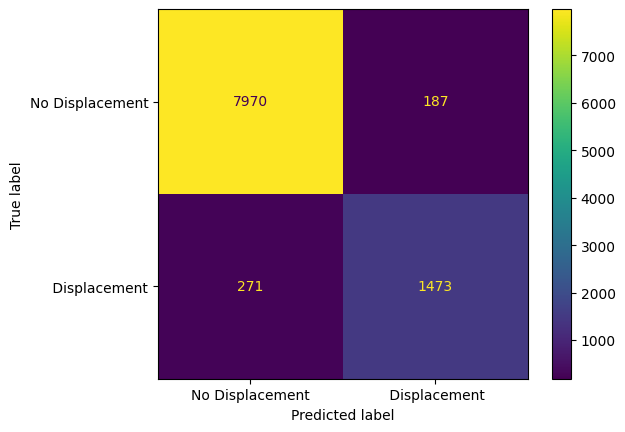

In [4]:
cm = sk.metrics.confusion_matrix(y_test, y_lrPred_test)
plot = sk.metrics.ConfusionMatrixDisplay(cm, display_labels=['No Displacement', ' Displacement'])
plot.plot()

# dispVar = 1 if displacement occurs, 0 otherwise
# plot y axis prob of 0 displacement, x axis = different features

### Multilinear regression

In [5]:
# as multilinear regression is meant to predict displacement value when it occurs,
# we only train and test the model on nonzero displacement values
earthquakeTrainingNZ = earthquakeTraining[earthquakeTraining['Disp'] >= 1]
earthquakeTestNZ = earthquakeTest[earthquakeTest['Disp'] >= 1]

X_trainML = earthquakeTrainingNZ[['KY1', 'PGV', 'T0050S', 'sa10', 'T']]
y_trainML = earthquakeTrainingNZ['Disp']
X_testML = earthquakeTestNZ[['KY1', 'PGV', 'T0050S', 'sa10', 'T']]
y_testML = earthquakeTestNZ['Disp']

# perform log transformation on training and test sets, except on columns containing zero or negative values
X_trainML_log=np.log(X_trainML.drop(columns=['T', 'KY1']))
X_testML_log=np.log(X_testML.drop(columns=['T','KY1']))
y_trainML_log = np.log(y_trainML)
y_testML_log = np.log(y_testML)

# add back in columns that cannot be log transformed
X_trainML_log[['T','KY1']]=X_trainML[['T','KY1']]
X_testML_log[['T', 'KY1']]=X_testML[['T', 'KY1']]

# add a constant to training and test sets
X_trainML_log = sm.add_constant(X_trainML_log) # adding a constant
X_testML_log = sm.add_constant(X_testML_log) # adding a constant

mlModel = sm.OLS(y_trainML_log, X_trainML_log).fit()

print(mlModel.summary())

                            OLS Regression Results                            
Dep. Variable:                   Disp   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     2738.
Date:                Wed, 03 May 2023   Prob (F-statistic):               0.00
Time:                        14:10:33   Log-Likelihood:                -8643.2
No. Observations:                6872   AIC:                         1.730e+04
Df Residuals:                    6866   BIC:                         1.734e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5260      0.070      7.558      0.0

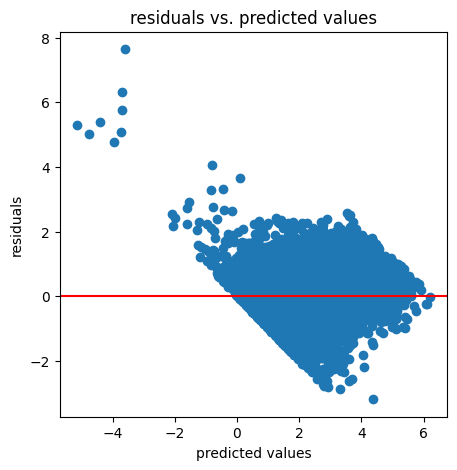

In [6]:
# residual plots for multilinear regression
mlPrediction = mlModel.predict(X_trainML_log)    # predict displacement using training set
mlPrediction_test = mlModel.predict(X_testML_log)    # predict displacement using test set

residuals=mlModel.resid
                     
fig,ax=plt.subplots(figsize=(5,5))
ax.scatter(mlPrediction,residuals)
ax.set_title('residuals vs. predicted values')
ax.set_xlabel('predicted values')
ax.set_ylabel('residuals')
ax.axhline(y=0,color='r')
# this plot is indicative of heteroskedasticity; standard dev increases as displacement increases

### Single Variable Residual Plots

Text(0, 0.5, 'residuals')

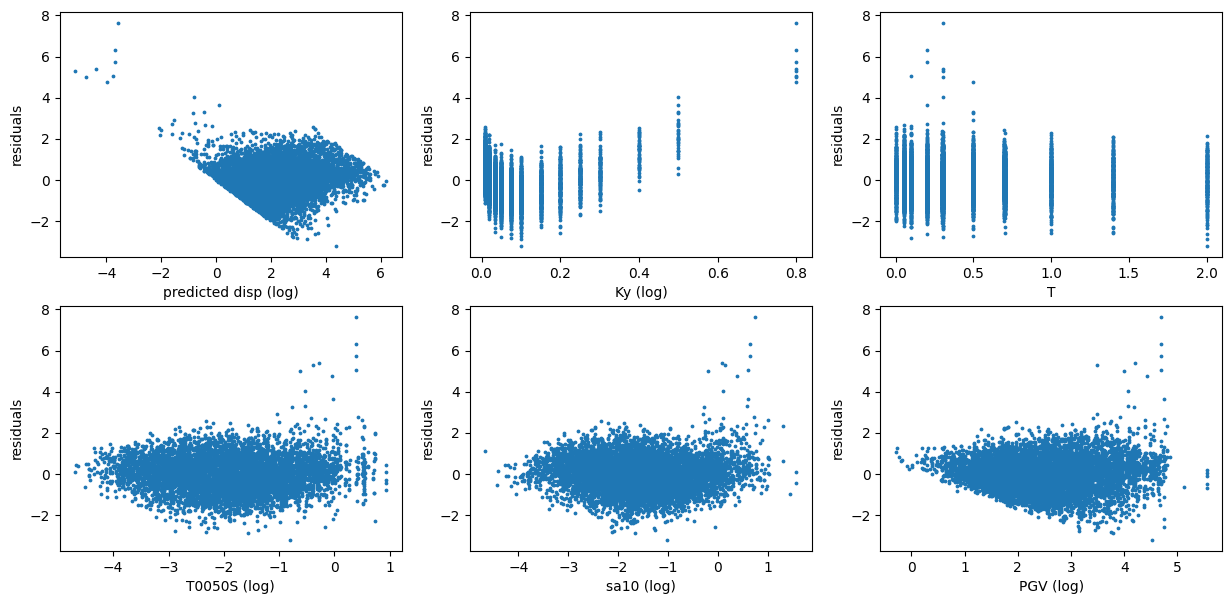

In [7]:
fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(15,7))
ax[0,0].scatter(mlPrediction,residuals ,s=3)
ax[0,0].set_xlabel('predicted disp (log)')
ax[0,0].set_ylabel('residuals')

ax[0,1].scatter(X_trainML_log['KY1'],residuals ,s=3)
ax[0,1].set_xlabel('Ky (log)')
ax[0,1].set_ylabel('residuals')

ax[0,2].scatter(X_trainML_log['T'],residuals ,s=3)
ax[0,2].set_xlabel('T')
ax[0,2].set_ylabel('residuals')

ax[1,0].scatter(X_trainML_log['T0050S'],residuals ,s=3)
ax[1,0].set_xlabel('T0050S (log)')
ax[1,0].set_ylabel('residuals')

ax[1,1].scatter(X_trainML_log['sa10'],residuals ,s=3)
ax[1,1].set_xlabel('sa10 (log)')
ax[1,1].set_ylabel('residuals')

ax[1,2].scatter(X_trainML_log['PGV'],residuals ,s=3)
ax[1,2].set_xlabel('PGV (log)')
ax[1,2].set_ylabel('residuals')

Text(0, 0.5, 'residuals')

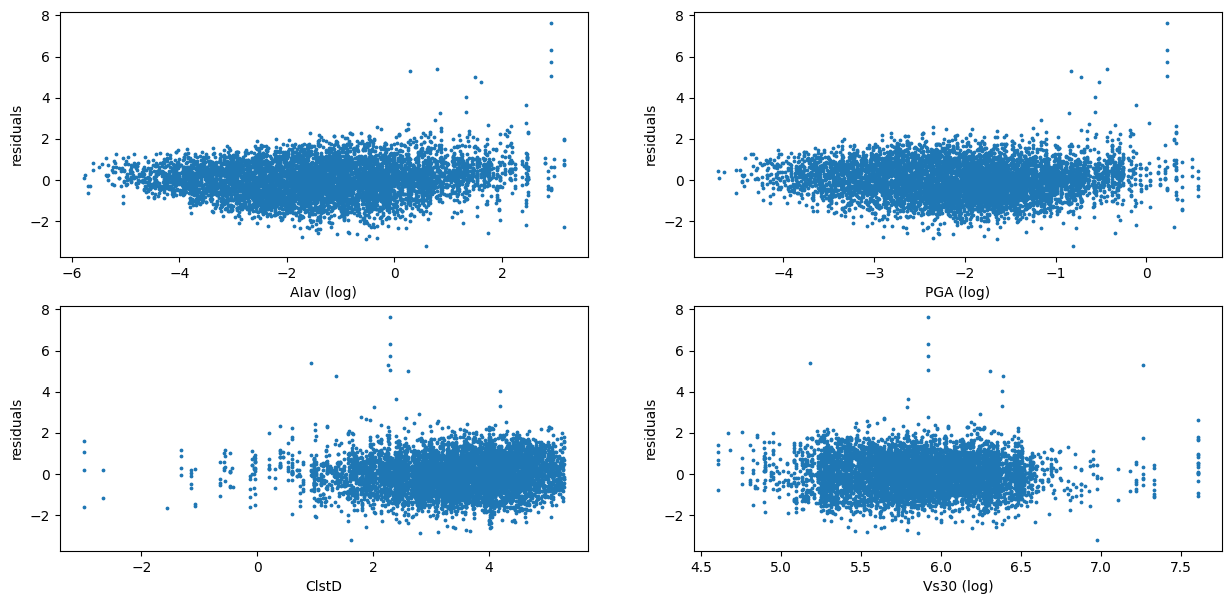

In [8]:
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(15,7))
ax[0,0].scatter(np.log(earthquakeTrainingNZ['AIav']),residuals ,s=3)
ax[0,0].set_xlabel('AIav (log)')
ax[0,0].set_ylabel('residuals')

ax[0,1].scatter(np.log(earthquakeTrainingNZ['PGA']),residuals ,s=3)
ax[0,1].set_xlabel('PGA (log)')
ax[0,1].set_ylabel('residuals')

ax[1,0].scatter(np.log(earthquakeTrainingNZ['ClstD']),residuals ,s=3)
ax[1,0].set_xlabel('ClstD')
ax[1,0].set_ylabel('residuals')

ax[1,1].scatter(np.log(earthquakeTrainingNZ['vs30']),residuals ,s=3)
ax[1,1].set_xlabel('Vs30 (log)')
ax[1,1].set_ylabel('residuals')

### Nonlinear Model

In [9]:
model = LinearRegression()
X_nl_train = earthquakeTrainingNZ[['KY1', 'PGV', 'M', 'sa10', 'T', 'T1300S', 'T1500S', 'T1000S']]
y_nl_train = earthquakeTrainingNZ['Disp']
X_nl_test = earthquakeTestNZ[['KY1', 'PGV', 'M', 'sa10', 'T', 'T1300S', 'T1500S', 'T1000S']]
y_nl_test = earthquakeTestNZ['Disp']

X_train_nl_log=np.log(X_nl_train.drop(columns=['T', 'M', 'T1300S','T1500S', 'T1000S']))
X_test_nl_log=np.log(X_nl_test.drop(columns=['T','M', 'T1300S', 'T1500S', 'T1000S']))
y_train_nl_log = np.log(y_nl_train)
y_test_nl_log = np.log(y_nl_test)

# add back in columns that cannot be log transformed
X_train_nl_log[['T','M', 'T1300S', 'T1500S', 'T1000S']]=X_nl_train[['T','M', 'T1300S', 'T1500S', 'T1000S']]
X_test_nl_log[['T', 'M', 'T1300S', 'T1500S', 'T1000S']]=X_nl_test[['T', 'M', 'T1300S', 'T1500S', 'T1000S']]
    
polyX = np.vstack([X_train_nl_log['KY1'], X_train_nl_log['KY1']**2, X_train_nl_log['KY1']*X_train_nl_log['sa10']*X_train_nl_log['T1300S'], X_train_nl_log['sa10']*X_train_nl_log['T1300S'], (X_train_nl_log['sa10']*X_train_nl_log['T1500S'])**2, X_train_nl_log['T1000S'], X_train_nl_log['T1000S']**2, X_train_nl_log['M'], X_train_nl_log['PGV']]).T 
model.fit(polyX, y_train_nl_log)
X_train_nl_log = sm.add_constant(X_train_nl_log) 
polyX = sm.add_constant(polyX) 
X_test_nl_log = sm.add_constant(X_test_nl_log)
nlPrediction = model.predict(X_train_nl_log)
nlPrediction_test = model.predict(X_test_nl_log)
nlModel = sm.OLS(y_train_nl_log, polyX).fit()
residuals= nlModel.resid
nlPrediction = model.predict(X_train_nl_log)
alsoResiduals = y_train_nl_log - nlPrediction
testResiduals = y_test_nl_log - nlPrediction_test
print(nlModel.summary())

                            OLS Regression Results                            
Dep. Variable:                   Disp   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     2885.
Date:                Wed, 03 May 2023   Prob (F-statistic):               0.00
Time:                        14:10:38   Log-Likelihood:                -7032.6
No. Observations:                6872   AIC:                         1.409e+04
Df Residuals:                    6862   BIC:                         1.415e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.4623      0.119    -62.717      0.0

c:\Users\Holt Leach\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\Holt Leach\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\Holt Leach\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


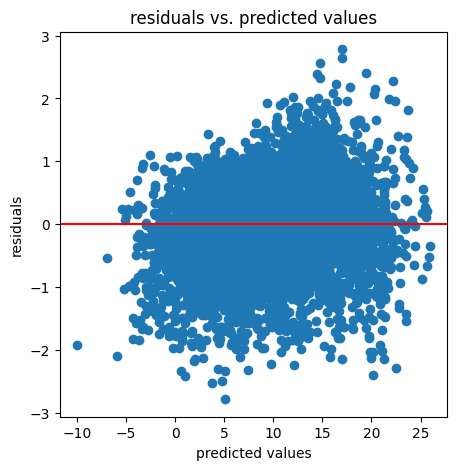

In [10]:
fig,ax=plt.subplots(figsize=(5,5))
ax.scatter(nlPrediction,residuals)
ax.set_title('residuals vs. predicted values')
ax.set_xlabel('predicted values')
ax.set_ylabel('residuals')
ax.axhline(y=0,color='r')

### Logistic regression classification report

In [11]:
print('LR Training Classification Report:\n', sk.metrics.classification_report(y_train, y_lrPred_train)) # gives the prediction accuracy of model
print('LR Test Classification Report:\n', sk.metrics.classification_report(y_test, y_lrPred_test)) # gives the prediction accuracy of model
# f1 is mean of precision & recall, shows accuracy in predicting that classifier's ability to classify data in that class compared to other classes
# precision = how many retreived items are relevant = true pos/all retreived elements
# recall = how many relevant items are retreived = true pos/total pos
# f1 score = measures accuracy of the test/classifier

LR Training Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     32730
           1       0.88      0.82      0.85      6872

    accuracy                           0.95     39602
   macro avg       0.92      0.90      0.91     39602
weighted avg       0.95      0.95      0.95     39602

LR Test Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      8157
           1       0.89      0.84      0.87      1744

    accuracy                           0.95      9901
   macro avg       0.93      0.91      0.92      9901
weighted avg       0.95      0.95      0.95      9901



### Prediction of additional scenarios

In [45]:
scenario1 = pd.read_csv('scenario1_additional-3.csv')
scenario2 = pd.read_csv('scenario2_additional-3.csv')

X_train1 = scenario1[['T', 'sa10', 'T0050S', 'pgv', 'durav', 'AIav']]
X_train2 = scenario2[['T', 'sa10', 'T0050S', 'pgv', 'durav', 'AIav']]

# perform log transformation except on columns containing zero or negative values
X_train1_log=np.log(X_train1.drop(columns=['T']))
X_train2_log=np.log(X_train2.drop(columns=['T']))

# add back in columns that cannot be log transformed
X_train1_log['T']=X_train1['T']
X_train2_log['T']=X_train2['T']

# add a constant to training and test sets
X_train1_log = sm.add_constant(X_train1_log) # adding a constant
X_train2_log = sm.add_constant(X_train2_log) # adding a constant

# additional predictions
scenario1Predict = mlModel.predict(X_train1_log)
scenario2Predict = mlModel.predict(X_train2_log)

Text(0, 0.5, 'predicted displacement')

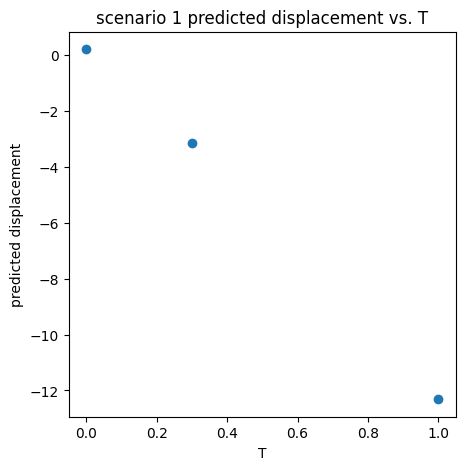

In [46]:
fig,ax=plt.subplots(figsize=(5,5))
ax.scatter(X_train1['T'],scenario1Predict)
ax.set_title('scenario 1 predicted displacement vs. T')
ax.set_xlabel('T')
ax.set_ylabel('predicted displacement')

Text(0, 0.5, 'predicted displacement')

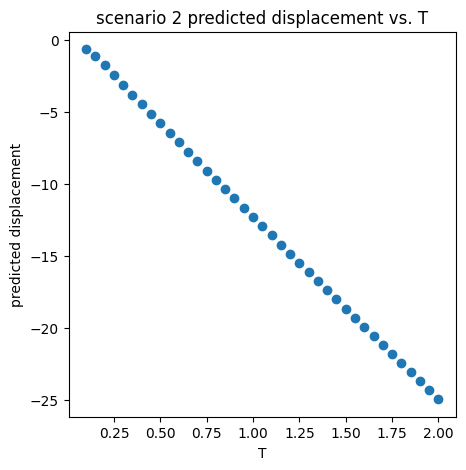

In [47]:
fig,ax=plt.subplots(figsize=(5,5))
ax.scatter(X_train2['T'],scenario2Predict)
ax.set_title('scenario 2 predicted displacement vs. T')
ax.set_xlabel('T')
ax.set_ylabel('predicted displacement')